## An introduction to matched-filtering
This tutorial is based on [Tutorial 2.1](https://github.com/gw-odw/odw-2020/blob/master/Day_2/Tuto_2.1_Matched_filtering_introduction.ipynb) from the GW Open Data Workshop \#3

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. We present matched filtering as a cross-correlation, in both the time domain and the frequency domain. In this tutorial we will perform a matched-filter search in simulated, Gaussian LIGO data, while in the next tutorial we will apply the same method on real LIGO data to find the first gravitational-wave event!

## Installation (un-comment and execute only if running on a cloud platform!)

In [ ]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [1]:
%matplotlib inline
import numpy as np
import pylab

### The cross-correlation
Before we talk about matched fitering in the context of gravitational-waves, we will introduce another signal processing concept: the cross-correlation. For two disrete data sets $h_{t}$ and $g_t$, it is defined as:
$$ CC_j = \sum_{t} g_{t}^{*}h_{t+j}.$$
The * symbol denotes complex conjugation, where the imaginary part of the signal switches sign:
$$x = 3+5i, \quad x^* = 3-5i.$$
The cross-correlation basically tells you how similar two data sets are as a function of the offset between them. So for example, if $g_t$ is a short signal that is contained at some time $j$ within $h_t$, the cross-correlation will be maximized at $j$. Let's look at a quick example of cross-correlation before applying it to gravitational-wave data:

In [2]:
g = [1,2,3]
h = [0, 1, 0.5]
cc = np.sum(np.multiply(h,g))
print(cc)

3.5


In this example, the two data sets $g_t$ and $h_t$ have the same number of elements, so we cannot shift them relative to each other. This means our cross-correlation is only valid for one point $j=0$ in the equation above. What if we look at arrays of different lengths?

In [3]:
g = [1,2]
h = [0, 1, 0.5, 1, 2, 0.46, 7]
n_shift = len(h)-len(g)
cc = []
for i in range(n_shift+1):
    cc.append(np.sum(np.multiply(h[i:i+2],g)))
print(cc)
cc2 = np.correlate(h, g)
print(cc2)

[2, 2.0, 2.5, 5, 2.92, 14.46]
[ 2.    2.    2.5   5.    2.92 14.46]


And let's look at the example above but make the data sets $h_t$ and $g_t$ complex:

In [4]:
g = [1+5j,2+1j]
h = [0, 1+1j, 0.5-0.3j, 1, 2+3j, 0.46+0.67j, 7-0.83j]
n_shift = len(h)-len(g)
cc = []
for i in range(n_shift+1):
    cc.append(np.sum(np.multiply(h[i:i+2],np.conjugate(g))))
print(cc)
cc2 = np.correlate(h, g)
print(cc2)

[(3+1j), (6.7-5.1j), (1-3.8j), (8-1j), (18.59-6.12j), (16.98-10.290000000000001j)]
[ 3.   +1.j    6.7  -5.1j   1.   -3.8j   8.   -1.j   18.59 -6.12j
 16.98-10.29j]


### Matched-filtering: Finding well-modelled signals in Gaussian noise

Matched filtering can be shown to be the optimal method for "detecting" signals--when the signal waveform is known--in Gaussian noise. We'll explore those assumptions a little later, but for now let's demonstrate how this works.

Let's assume you have a stretch of white noise to start. Remember that this means that the noise has not been "colored" by the PSD, and is simply Gaussian with $\mu=0$ and $\sigma=1$.

In [2]:
# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds
dt = 1./sample_rate # time spacing

# Generate a long stretch of white noise: the data series and the time series.
data = np.random.normal(size=[sample_rate * data_length])
times = np.arange(0, data_length, dt)

And then let's add a gravitational wave signal to some random part of this data. This will be a binary black hole signal with each component being $10~M_{\odot}$.

In [3]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform
# but here, we'll use defaults for everything except the masses.
# It returns both hplus and hcross, but we'll only use hplus for now.
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

The amplitude of gravitational-wave signals is normally of order 1E-20 as we saw in the previous tutorial. To demonstrate our method on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white noise as a signal-to-noise ratio. 

Text(0, 0.5, 'Normalized amplitude')

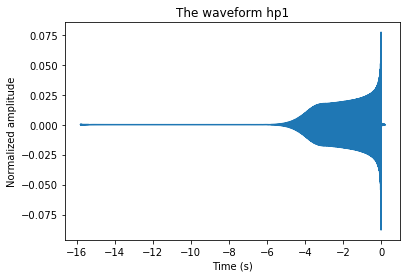

In [4]:
hp1 = hp1 / max(np.correlate(hp1,hp1, mode='full'))**0.5

# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.
pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

Now we will "inject" the waveform at a random point in the data given by `waveform_start`. The waveform amplitude is small compared to the data amplitude, so when you plot the data, you can't see the wavefrom by eye. This is why searching for gravitational-wave signals in data is so hard!

Text(0, 0.5, 'Normalized amplitude')

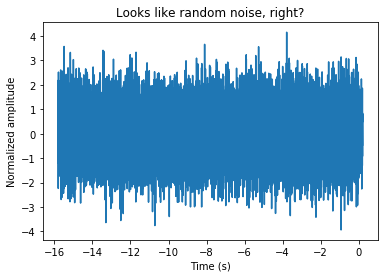

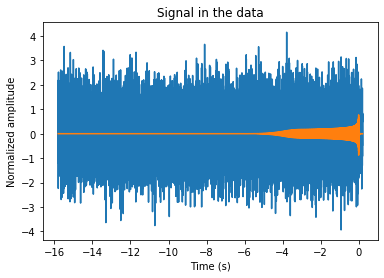

In [5]:
waveform_start = np.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

To search for this signal we can cross-correlate the signal with the entire dataset -> Not in any way optimized at this point, just showing the method.

We will do the cross-correlation in the time domain, once for each time step. The signal is shorter than our data segment, so the number of elements in the cross-correlation array is the difference between the length of the signal and data arrays, just like before. In this case, the signal is $g_t$ and the data is $h_t$. This will run slowly.

In [6]:
# first create an empty cc array
cross_correlation = []
hp1_numpy = hp1.numpy()
n_shift = len(data) - len(hp1_numpy)
for i in range(n_shift):
    cross_correlation.append(np.sum(hp1_numpy * data[i:i+len(hp1_numpy)]))

Now let's plot the cross-correlation versus time. First, we need to calculate the time array. It should have `n_shift` elements, so how many seconds does that correspond to for our $\Delta t$?

Text(0, 0.5, 'Cross-correlation')

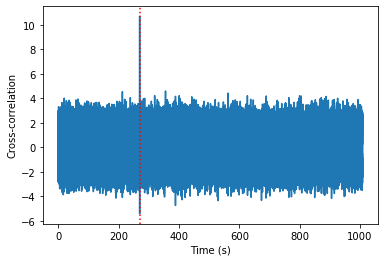

In [7]:
# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
times = np.arange(0, n_shift*dt, dt)
pylab.figure()
pylab.plot(times, cross_correlation)
pylab.axvline(waveform_start*dt, color='r', ls=':')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

Here you can see that the largest spike from the cross-correlation comes at the time of the signal. In this way, the cross-correlation is like a **signal-to-noise ratio**, or SNR, which tells you how loud the signal is compared to the noisy data. We only really need one more ingredient to describe matched-filtering: "Colored" noise that matched the LIGO PSD. 

Let's repeat the process, but generate a stretch of data colored with the Advanced LIGO PSD. We'll use a PyCBC library to do this. The `psd` varible we define below is a `pycbc.psd` object. It has the same shape in the frequency domain as the advanced LIGO PSD that we looked at in the second tutorial, but it also has some other pycbc methods.

In [8]:
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

Instead of generating white noise and then coloring it ourselves like we did previously by multiplying it by the ASD, we will use a prebuilt `pycbc` function to generate Gaussian noise colored with the LIGO PSD. We can also use `pycbc` to calculate the PSD from the data using the averaging method we discussed previously.

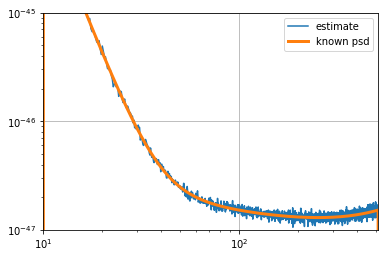

In [9]:
# Generate colored noise
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, dt, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4*sample_rate) # the length of each segment being averaged in number of samples
seg_stride = int(seg_len / 2) # offset between segments in number of samples
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.legend()
pylab.grid()
pylab.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

Then all we need to do is to "whiten" both the data, and the template waveform. This can be done, in the frequency domain, by dividing by the PSD. This *can* be done in the time domain as well, but it's more intuitive in the frequency domain

In [10]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The PSD, sampled properly for the signal
signal_len = float(len(hp1))*dt
delta_f = 1.0 / signal_len
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

The `to_frequencyseries()` method takes a Fourier transform of the time-domain data and signal. In the previous cell, we defined two PSDs, `psd_td` and `psd_hp1` which are the same except they have different frequency resolutions since they need to match the Fourier-transformed data and signal which have different lengths in the time domain. We then divide the two frequency series by their respective PSDs, and take the inverse Fourier transfrom to get the whitened data back in the time domain. We multiply the signal by $1\times 10^{-21}$ so that the amplitude matches the expected amplitude spectral density for gravitational-wave data.

In [11]:
# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template. 
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

We now recompute the cross-correlation using the whitened data and signal template, and plot it at the end.

Text(0, 0.5, 'Cross-correlation')

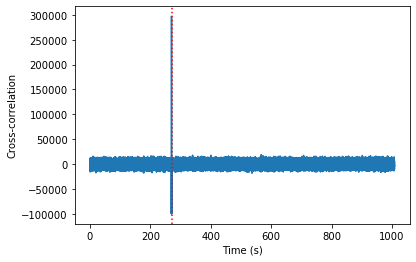

In [12]:
# Now let's re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = []
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation.append(np.sum(hp1n * datan[i:i+len(hp1n)]))

# plot the cross-correlation in the time domain. Superimpose the location of the end of the signal.
# Note how much bigger the cross-correlation peak is, relative to the noise level,
# compared with the unwhitened version of the same quantity. SNR is much higher!
pylab.figure()
n_shift = len(datan) - len(hp1n)
times = np.arange(0, n_shift*dt, dt)
pylab.plot(times, cross_correlation)
pylab.axvline(waveform_start*dt, color='r', ls=':')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

# Challenge!

* What is the mean and standard deviation of the whitened data timeseries? (We have not been careful in normalizing the whitened data properly). Plot it in a histogram. Is it a Gaussian? What if you restrict the range of the histogram to $\pm 5\sigma$ (by passing the `range=[-5*std, 5*std]` argument to the call to `pylab.hist`). Do the data look more Gaussian? You will have to use the definition of the Gaussian distribution from the second tutorial. 
* Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal by restricting the range as you did above, is it a Gaussian? What are the mean and standard deviation?
* Find the location of the peak in time, and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series). You can check that you've got the right time by comparing with the plot of the cross-correlation above.
* Bonus Challenge: Repeat this process, but instead of using a waveform with mass1=mass2=$10~M_{\odot}$, try 15, 20, or 25. Plot the SNR vs mass. Careful! Using lower masses (eg, mass1=mass2=$1.4~M_{\odot}$) will not work here. Why?